# Task1 Data Generation
We created a Wechat group of **6 people**, where each person sent **50 WREs**, each containing **50r**, distributed to all 6 people.

That is to say, totally **300 i.i.d. samples from the distribution**.

# Task2 Data Processing
## Raw Info Collecting
We made use of an auto-test software **Airtest**(Based on Image Recognition) to traverse the ChatLog to get **Snapshots of WRE Reception Record Infos**.
![Airtest](./SupportImages/Airtest.png)

## Data Extracting and Processing
We deployed **gemma3:27b** model with **Ollama** on **WSL** and **Dify** with **Docker** on **Windows Host**. Gemma3 is able to **read images**.

Then we built a workflow on **Dify**, which is able to call **gemma3** to extract **Receiver Order Index** and **Receive Amount** from the **Snapshots**, and **structure-output json files** for later processing.
![Dify](./SupportImages/Dify.png)

Then we wrote 2 python scripts:
- `DataExtractor.py` : Making use of **Dify's API** to **upload snapshots** and **get the returned jsons**.
- `DataProcessor.py` : 
  - Get input snapshots
  - Call DataExtractor.py in loops
  - Do postprocess and output data as a json file
  
### Visualization
`Datavisualizer.py`
- A **Scatter** showing how much **receivers with different Receiver Order Index** receives   (*x:index* - *y:amount*)
- A **Boxplot** showing how much **receivers with different Receiver Order Index** receives   (*x:index* - *y:amount*)
- 6 **Histograms** showing the distribution of each receiver with different **Receiver Order Index**'s receive amount   (*x:amount* - *y:frequency*)

In [ ]:
import requests
import json
import os
import mimetypes
import glob
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "DejaVu Sans"]

## DataExtractor

In [ ]:
# ====== Configuration ======
LOCAL_DIFY_URL = "http://localhost"
API_KEY = "app-5Wjz73iI02lHt23TiDULPkIL"
USER_ID = "PositionZero"


def upload_file(file_path, user, base_url, api_key):
    upload_url = f"{base_url}/v1/files/upload"
    headers = {
        "Authorization": f"Bearer {api_key}",
    }

    try:
        with open(file_path, "rb") as file:
            mime_type, _ = mimetypes.guess_type(file_path)
            if not mime_type:
                mime_type = "application/octet-stream"

            files = {"file": (os.path.basename(file_path), file, mime_type)}
            data = {"user": user}

            response = requests.post(
                upload_url, headers=headers, files=files, data=data, timeout=60
            )
            if response.status_code == 201 or response.status_code == 200:
                return response.json()
            else:
                print(f"❌ 文件上传失败，状态码: {response.status_code}")
                try:
                    print(response.json())
                except:
                    print(response.text)
                return None
    except Exception as e:
        print(f"❌ 上传发生错误: {str(e)}")
        return None


def run_workflow(file_id, user, base_url, api_key, response_mode="blocking"):
    workflow_url = f"{base_url}/v1/workflows/run"
    headers = {"Authorization": f"Bearer {api_key}", "Content-Type": "application/json"}

    data = {
        "inputs": {
            "RedPacketInfo": {
                "transfer_method": "local_file",
                "upload_file_id": file_id,
                "type": "image",
            }
        },
        "response_mode": response_mode,
        "user": user,
    }

    try:
        response = requests.post(workflow_url, headers=headers, json=data, timeout=120)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"❌ 工作流执行失败，状态码: {response.status_code}")
            try:
                print(response.json())
            except:
                print(response.text)
            return {
                "status": "error",
                "message": f"Failed to execute workflow, status code: {response.status_code}",
            }
    except Exception as e:
        print(f"❌ 运行发生错误: {str(e)}")
        return {"status": "error", "message": str(e)}


def extract_data_from_image(
    image_path, user_id=USER_ID, base_url=LOCAL_DIFY_URL, api_key=API_KEY
):
    if not os.path.exists(image_path):
        print(f"❌ 找不到图片文件，请检查路径：{image_path}")
        return None

    upload_resp = upload_file(image_path, user_id, base_url, api_key)

    if upload_resp and "id" in upload_resp:
        file_id = upload_resp["id"]

        run_resp = run_workflow(file_id, user_id, base_url, api_key)

        # 解析 run 响应以提取 outputs
        run_output = None
        if (
            isinstance(run_resp, dict)
            and "data" in run_resp
            and isinstance(run_resp["data"], dict)
            and "outputs" in run_resp["data"]
        ):
            run_output = run_resp["data"]["outputs"]
        else:
            run_output = run_resp

        try:
            text_content = run_output.get("text")
            if "```json" in text_content:
                text_content = text_content.replace("```json", "").replace("```", "")

            parsed_json = json.loads(text_content)

            # Attempt to locate the list of items
            info = None
            if isinstance(parsed_json, dict):
                # 1. Try exact match
                if "red_packets" in parsed_json:
                    info = parsed_json["red_packets"]
                # 2. Search for any list value if specific key is missing
                else:
                    for key, value in parsed_json.items():
                        if isinstance(value, list):
                            info = value
                            break
            elif isinstance(parsed_json, list):
                # 3. The root object itself is the list
                info = parsed_json

            if info is None:
                raise ValueError("Cannot locate a valid data list in response.")

            data = []
            for i in range(len(info) - 1, -1, -1):
                amount_str = info[i].get("ReceiveAmount", "0")
                amount_str = str(amount_str).replace("元", "")
                data.append(float(amount_str))
            return data
        except Exception as e:
            print(f"Error parsing data: {e}")
            return None

    else:
        print("文件上传失败，无法执行工作流")
        return None


## DataProcessor

In [ ]:
PLOTS_DIR = "Plots/Raw_Wechat/"
OUTPUT_DIR = "Output/"  # Temporary output directory for test-generated data
DATABASE_DIR = "Database/"  # Acknowledged and manually transferred long-term data storage from OUTPUT_DIR

def process_all_snapshots():
    # Cleanup: Delete all temp generated .jpgs in Snapshots/
    jpg_files = glob.glob(os.path.join("Snapshots", "*.jpg"))
    if jpg_files:
        for f in jpg_files:
            try:
                os.remove(f)
            except Exception as e:
                print(f"Failed to delete {f}: {e}")

    snapshot_files = glob.glob(os.path.join("Snapshots", "info*.png"))

    snapshot_files.sort()

    all_data = []

    for file_path in snapshot_files:
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        file_data = extract_data_from_image(file_path)

        if file_data:
            all_data.append(file_data)
        else:
            print(f"Failed to extract data from {file_path}")

    if not all_data:
        print("No data collected.")
        return

    # Save all_data to a JSON
    output_json_path = os.path.join(OUTPUT_DIR, "Wechat_Samples.json")

    try:
        with open(output_json_path, "w", encoding="utf-8") as f:
            json.dump(all_data, f, ensure_ascii=False, indent=4)
    except Exception as e:
        print(f"Error saving data to file: {e}")


## DataVisualizer

In [ ]:
def visualize_data(all_data):
    plt.figure(figsize=(12, 6))

    # Data logic for plotting
    # Example: all_data = [[A1, B1], [A2, B2], [A3, B3]]
    # Index 0 (A): Values (A1, A2, A3)
    # Index 1 (B): Values (B1, B2, B3)

    # Determine maximum dimension length
    max_len = max(len(d) for d in all_data) if all_data else 0

    if not os.path.exists(PLOTS_DIR):
        os.makedirs(PLOTS_DIR)

    # 1. Overlay Plot: Vertical Scatter (Index vs Value)
    plt.figure(figsize=(12, 6))

    # 1. Prepare data by dimension
    data_by_dimension = []
    for dim_idx in range(max_len):
        values = [snap[dim_idx] for snap in all_data if dim_idx < len(snap)]
        data_by_dimension.append(values)

    # 2. Overlay Plot: Vertical Scatter (Index vs Value)
    plt.figure(figsize=(12, 6))

    for dim_idx, values in enumerate(data_by_dimension):
        if values:
            # Add random jitter to x coordinates
            jitter = np.random.uniform(-0.1, 0.1, len(values))
            x = np.array([dim_idx] * len(values)) + jitter

            plt.scatter(
                x,
                values,
                alpha=0.6,
                s=50,
                label=f"Dim {dim_idx}" if dim_idx == 0 else "",
            )

    plt.title("All Value Distribution (Scatter)")
    plt.xlabel("Receiver Order Index")
    plt.ylabel("Value (元)")
    plt.xticks(range(max_len))
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # 3. Overlay Plot: Vertical Boxplot (Index vs Value)
    plt.figure(figsize=(12, 6))
    plt.boxplot(data_by_dimension, tick_labels=range(max_len))

    plt.title("All Value Distribution (Boxplot)")
    plt.xlabel("Receiver Order Index")
    plt.ylabel("Value (元)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # 4. Individual Plots: Histogram (Value Distribution)
    for dim_idx, values in enumerate(data_by_dimension):
        if not values:
            continue

        plt.figure(figsize=(10, 6))

        plt.hist(values, bins=20, color="teal", alpha=0.7, edgecolor="black")

        plt.title(f"Distribution Histogram for Receiver # {dim_idx}")
        plt.xlabel("Value (元)")
        plt.ylabel("Frequency")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()


## Main

Loading data from Database/Wechat_Samples.json...


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

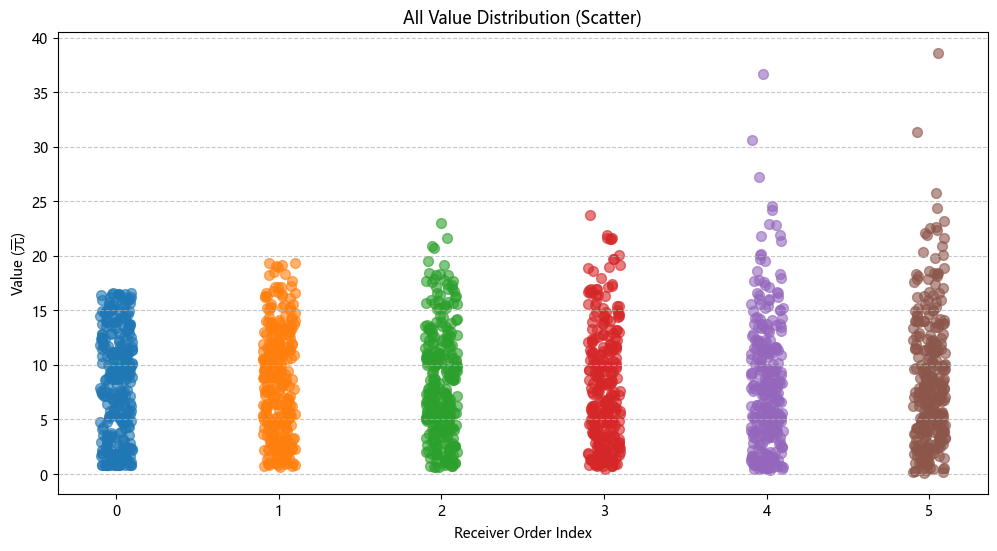

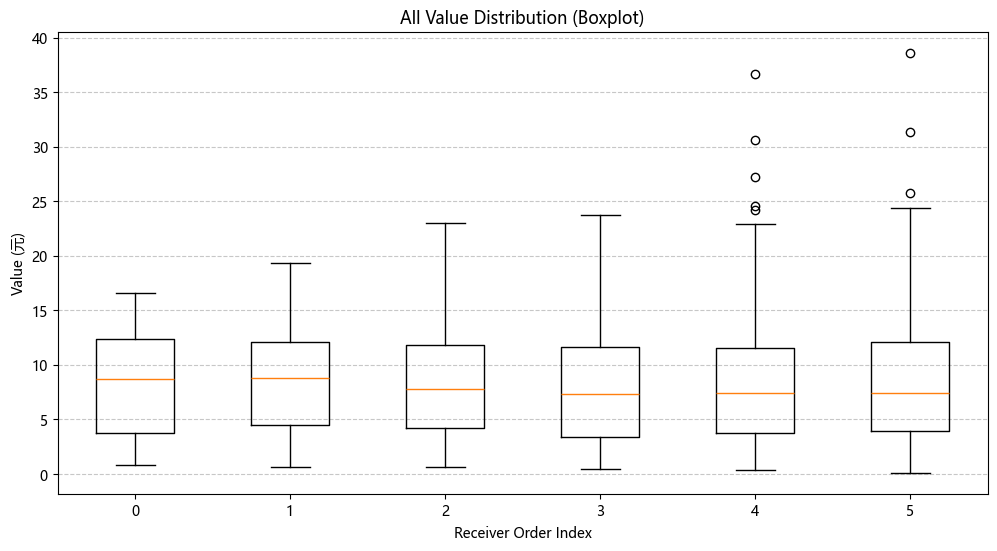

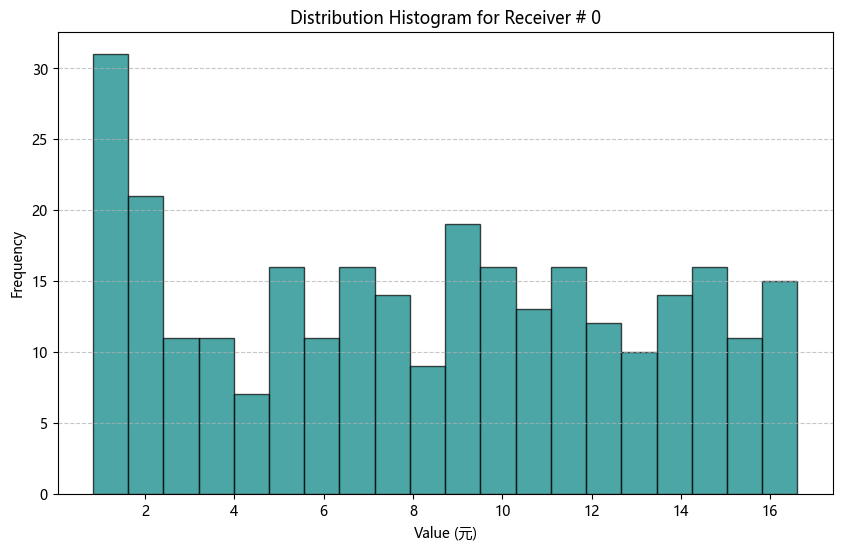

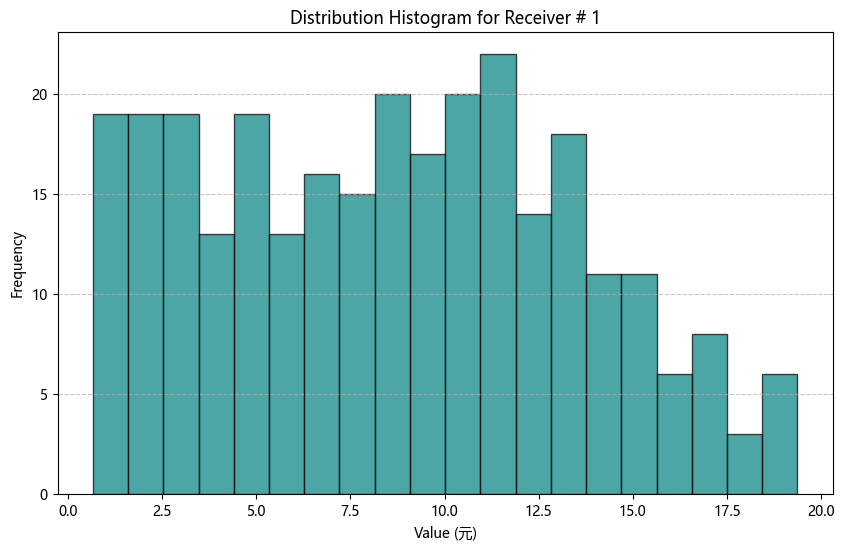

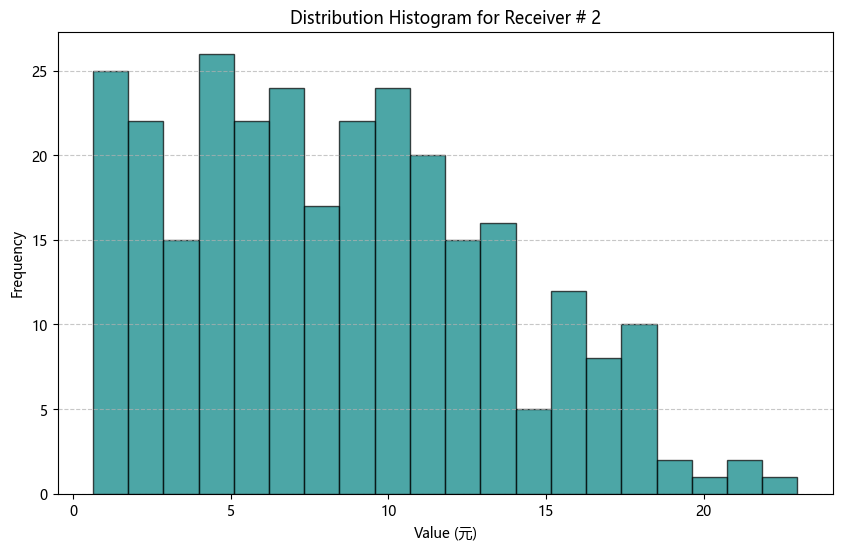

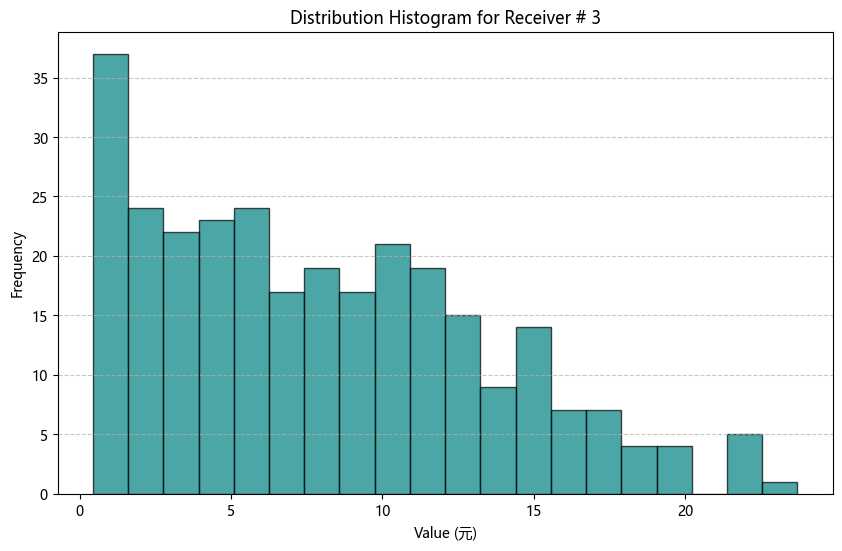

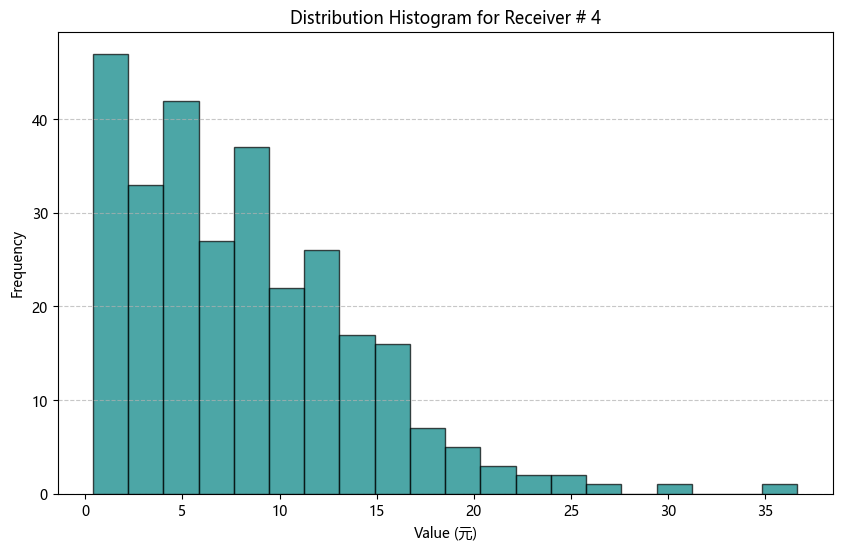

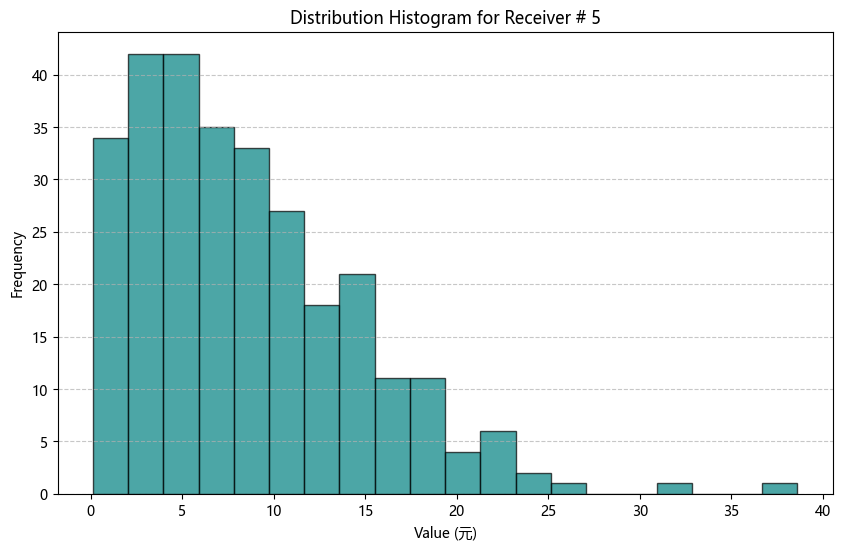

: 

In [ ]:
# Load Wechat_Samples.json if it exists, otherwise process snapshots
data_path = os.path.join(DATABASE_DIR, "Wechat_Samples.json")

if os.path.exists(data_path):
    print(f"Loading data from {data_path}...")
    try:
        with open(data_path, "r", encoding="utf-8") as f:
            all_data = json.load(f)
        visualize_data(all_data)
    except Exception as e:
        print(f"Error loading data from file: {e}")
        print("Falling back to processing snapshots...")
        process_all_snapshots()
else:
    process_all_snapshots()

# Task5 Diffusion Model

Using the 300 samples, we trained a **DDPM(Denoising Diffusion Probabilistic Model)** to generate new samples from the same target distribution.

## Core Concepts
- ### Forward Process
  
  ***Objective***: Gradually add **Gaussian Noise** to a ***normalized*** sample $\mathbf{X}_0$ to get nearly pure noise $\mathbf{X}_t$.
  
  **For DDPM**, the process is a **Markov Chain**.
  
  Given parameters $\epsilon \sim \mathcal{N}(0,1)$ and $\beta_t \in (0,1)$
  $$\mathbf{X}_{t+1} = \sqrt{1-\beta_t} \cdot \mathbf{X}_t+\beta_t \cdot \epsilon \Rightarrow \lim_{t\rightarrow \infty} \mathbf{X}_t \sim \mathcal{N}(0,1)$$

  Let $\alpha_t=1-\beta_t, \; \bar{\alpha}_t=\prod_{i=1}^t \alpha_i$, we have:
  $$\mathbf{X}_t = \sqrt{\bar{\alpha}_t} \cdot \mathbf{X}_0 + (1-\bar{\alpha}_t) \cdot \epsilon$$

  or more commonly seen in the form of PDF as: $$q(\mathbf{x}_t\mid \mathbf{x}_0) = \sqrt{\bar{\alpha}_t} \cdot \mathbf{x}_0 + (1-\bar{\alpha}_t) \cdot \epsilon$$

- ### Reverse Process (Denoise)
  
  ***Objective***: Train a **Neural Network** to rebuild data from **Gaussian Noise** $\mathbf{X}_T$.

  The rebuilding process is also a **Markov Chain**. 
  
  Denote $\mathbf{X}_{a:b}$ as the joint distribution of $\mathbf{X}_a,\mathbf{X}_{a+1},\dots ,\mathbf{X}_b$, we have:
  $$ p_\theta(\mathbf{x}_{0:T})= p_\theta(\mathbf{x}_T)\prod_{t=1}^T p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t)$$

  ***Training Objective***: Maximize ***negative log-likelihood*** of generating the real sample $\mathbf{X}_0$.
  $$\theta=\arg\max_\theta (-\log p_\theta(\mathbf{x}_0))$$

  Since it's ***intractable*** to calculate integral of the joint PDF to get $p_\theta(\mathbf{x}_0)$, we calculate the **Evidence Lower Bound(ELBO)**,

  which is the expectation below.
  ![ELBO](./SupportImages/ELBO.png "Derivation of ELBO")

  Then the ELBO can be transformed and simplized to the form below.
  $$-\mathbb{E}_q[\sum_{t>1}D_{KL}(r(\mathbf{x}_{t-1}\mid \mathbf{x}_t,\mathbf{x}_0) || p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t))]$$
  where $r(\mathbf{x}_{t-1}\mid \mathbf{x}_t,\mathbf{x}_0)$ is called the ***true posterior*** since it's conditioned on $\mathbf{x}_0$ in extra, and it has a ***closed-form expression*** we can compute.
  $$r(\mathbf{x}_{t-1}\mid \mathbf{x}_t,\mathbf{x}_0) = \mathcal{N}(\tilde{\mu}_t,\tilde{\beta}_t)$$

  $D_{KL}$ is called the ***KL-Divergence*** which can evaluate **how close** 2 distribution is.

  Therefore, during training, our objective is to ***minimize the distance*** of each **estimated posterior** $p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t)$ to the **true posterior** $r(\mathbf{x}_{t-1}\mid \mathbf{x}_t,\mathbf{x}_0)$.

  Since we have a theorem says **reverse of a Gaussian Markov is also Gaussian**, we set:
  $$p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t) = \mathcal{N}(\mu_\theta,\sigma_t)$$

  In this case, $D_{KL}$ can be simplized to $L^2$ norm:
  $$D_{KL}=\frac{1}{2\sigma_t^2} ||\tilde{\mu}_t-\mu_\theta(\mathbf{x}_t,t)||^2$$

  Given the expression of $\tilde{\mu}_t$ and $\mu_\theta(\mathbf{x}_t,t)$:
  $$\tilde{\mu}_t=\frac{1}{\sqrt{\alpha_t}}(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\cdot \epsilon) \qquad 
  \mu_\theta(\mathbf{x}_t,t)=\frac{1}{\sqrt{\alpha_t}}(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\cdot \epsilon_\theta(\mathbf{x}_t,t))$$
  where $\epsilon_\theta(\mathbf{x}_t,t)$ is the **estimate of noise** added to $\mathbf{X}_0$ to produce $\mathbf{X}_t$

  We have our final ***Loss Function***:
  $$\mathcal{L}=\mathbb{E}_q[\sum_{t>1}\frac{\beta_t^2}{2\sigma_t^2\alpha_t(1-\bar{\alpha}_t)}||\epsilon-\epsilon_\theta(\mathbf{x}_t,t)||^2]$$

### Practical Implementation Optimization
In practice (as in our `DiffusionModelTrainer.py`), we implement a **Simplified Loss(MSE)**.
   $$ \mathcal{L}_{\text{simple}} = \mathbb{E}_{t, \mathbf{x}_0, \epsilon} [||\epsilon - \epsilon_\theta(\mathbf{x}_t, t)||^2] $$

This involves two key changes:
1. **Replacing Sum with Expectation (Stochastic Sampling)**:
   The theoretical calculation requires a sum over all time steps: $\mathcal{L} = \sum_{t=1}^T L_t$.
   
   Mathematically, a sum is equivalent to an expectation over a uniform distribution scaled by a constant:
   $$ \sum_{t=1}^T L_t = T \cdot \mathbb{E}_{t \sim \mathcal{U}(1,T)}[L_t] $$
   
   Therefore, instead of computing the forward/backward pass for **all 1000 steps** for every single sample (which is computationally expensive), we **randomly sample one $t$** for each sample in the batch.
2. **Discarding Weighting Coefficients**:
   Neglecting the weighting term down-weights the loss at small $t$ (where noise is small), encouraging the model to focus on more difficult, noisier steps ($t$ large), which empirically(as in the original paper) improves sample quality.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import os
import math
import matplotlib.pyplot as plt

# ===== Configuration =====
DATA_PATH = os.path.join("Database", "Wechat_Samples.json")
MODEL_DIR = "DiffusionModel"

BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 1000
TIMESTEPS = 1000
BETA_START = 1e-4
BETA_END = 0.02
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 6
HIDDEN_DIM = 128

## DiffusionModelTrainer

In [ ]:
# ===== Dataset and Data Loading =====
class WechatDataset(Dataset):
    def __init__(self, json_path):
        with open(json_path, "r") as f:
            data = json.load(f)
        self.data = torch.tensor(data, dtype=torch.float32)

        # Normalization
        self.mean = self.data.mean(dim=0)
        self.std = self.data.std(dim=0)
        self.normalized_data = (self.data - self.mean) / (self.std + 1e-8)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.normalized_data[idx]


# ===== Model Components =====
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Main network
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        self.mid_layers = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.final_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, t):
        # Embed time
        t_emb = self.time_mlp(t)

        # Embed input
        x_emb = self.input_layer(x)

        # Concatenate x embedding and time embedding
        # Note: We concatenate them or add them. Concatenating to input of interaction layers is common.
        # Here we concat along feature dimension
        h = torch.cat([x_emb, t_emb], dim=1)

        h = self.mid_layers(h)
        return self.final_layer(h)


# ===== Training Logic =====
def get_beta_schedule(timesteps, start, end):
    return torch.linspace(start, end, timesteps)


def train():
    # 1. Prepare Data
    if not os.path.exists(DATA_PATH):
        print(f"Error: Database file not found at {DATA_PATH}")
        return

    dataset = WechatDataset(DATA_PATH)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # 2. Diffusion Setup
    betas = get_beta_schedule(TIMESTEPS, BETA_START, BETA_END).to(DEVICE)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    # 3. Model Setup
    model = DiffusionModel(INPUT_DIM, HIDDEN_DIM).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    # 4. Training Loop
    model.train()
    loss_history = []
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch_idx, batch in enumerate(dataloader):
            batch = batch.to(DEVICE)

            # Sample t uniformly
            t = torch.randint(0, TIMESTEPS, (batch.size(0),), device=DEVICE).long()

            # Sample noise
            noise = torch.randn_like(batch)

            # Forward diffusion q(x_t | x_0)
            # x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * noise
            sqrt_alpha_cumprod_t = torch.sqrt(alphas_cumprod[t])[:, None]
            sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alphas_cumprod[t])[:, None]

            x_t = sqrt_alpha_cumprod_t * batch + sqrt_one_minus_alpha_cumprod_t * noise

            # Predict noise
            noise_pred = model(x_t, t)

            # Loss
            loss = criterion(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)


    # 5. Save Model and Stats
    torch.save(model.state_dict(), os.path.join(MODEL_DIR, "diffusion_model.pth"))
    # Save normalization stats for generation later
    stats = {"mean": dataset.mean.tolist(), "std": dataset.std.tolist()}
    with open(os.path.join(MODEL_DIR, "model_stats.json"), "w") as f:
        json.dump(stats, f)

    # 6. Visualize Loss
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Evolution of Training Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(MODEL_DIR, "loss_evolution.png"))
    plt.show()


if __name__ == "__main__":
    train()